# -- SETUP THE ENVIRONMENT

In [1]:
%load_ext tensorboard

In [2]:
%pip install -q dagshub mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.2/211.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 66.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB

In [12]:
# -- General Import
import dagshub
import datetime
import keras
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import seaborn as sns
import tensorflow as tf

# -- Keras
from keras.layers import Conv2D, Dense, Dropout, BatchNormalization,\
                         MaxPooling2D, ReLU, Rescaling
from keras.metrics import Accuracy, F1Score, Precision, Recall,\
                          TopKCategoricalAccuracy
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory, to_categorical

In [4]:
## - Prepare Dagshub and MLFlow tracking
dagshub.init(repo_owner='<your_name>', repo_name='<your_repo>', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=0b3eb400-2baa-4759-9139-f31acaf7a2dd&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=a2fc79bbb03340f9cb68c63398e4c6136a61c39a442a2b38b0a5c6e0cd25b9f4




Initialized MLflow to track repo "CharleyDL/neo_aissyr"

Repository CharleyDL/neo_aissyr initialized!

# -- LOADING DATASET

In [5]:
directory_full = '/path/to/your/dataset/'


full_ds = image_dataset_from_directory(
    directory_full,
    labels='inferred',
    label_mode='categorical',

    subset='both',
    validation_split=0.2,

    image_size=(30,30),
    batch_size=64,
    color_mode='grayscale',

    seed=42
)

train_ds, val_ds = full_ds

Found 7876 files belonging to 284 classes.
Using 6301 files for training.
Using 1575 files for validation.


In [6]:
class_names = train_ds.class_names
len(class_names)

284

# -- VISUALIZATION DATA

##### └── Train

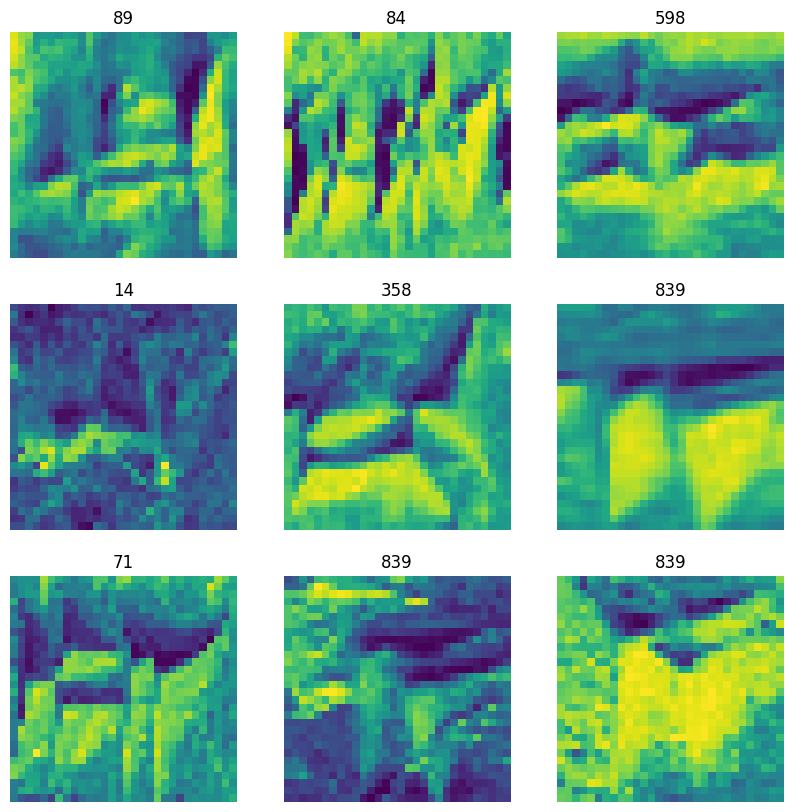

In [7]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    ## - convert one-hot encoder label to integer label
    integer_labels = np.argmax(labels, axis=1)

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.title(class_names[integer_labels[i]])
        plt.axis("off")
        plt.imshow(images[i].numpy().astype("uint8"))

##### └── Validation

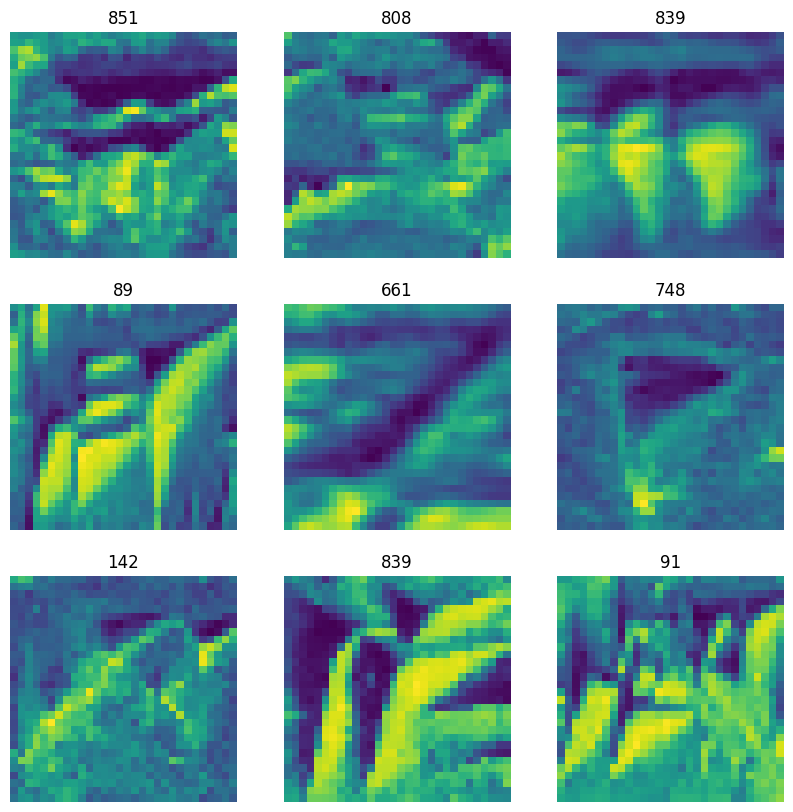

In [8]:
plt.figure(figsize=(10, 10))

for images, labels in val_ds.take(1):
    ## - convert one-hot encoder label to integer label
    integer_labels = np.argmax(labels, axis=1)

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.title(class_names[integer_labels[i]])
        plt.axis("off")
        plt.imshow(images[i].numpy().astype("uint8"))

# -- PREPROCESSING DATA

In [9]:
## - Normalization
train_ds = train_ds.map(lambda x, y: (Rescaling(1./255)(x), y)) # train
val_ds = val_ds.map(lambda x, y: (Rescaling(1./255)(x), y)) # test

## - Check the normalization
print("Train Set:")
for image, label in train_ds.take(1):
    print("Minimum pixel value:", tf.reduce_min(image))
    print("Maximum pixel value:", tf.reduce_max(image))

print("\nValidation Set:")
for image, label in val_ds.take(1):
    print("Minimum pixel value:", tf.reduce_min(image))
    print("Maximum pixel value:", tf.reduce_max(image))

Train Set:
Minimum pixel value: tf.Tensor(0.0, shape=(), dtype=float32)
Maximum pixel value: tf.Tensor(0.9546841, shape=(), dtype=float32)

Validation Set:
Minimum pixel value: tf.Tensor(0.0, shape=(), dtype=float32)
Maximum pixel value: tf.Tensor(0.98671573, shape=(), dtype=float32)


In [10]:
## - Buffered Prefetching
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

<br />
<br />

------

# -- MODEL 8C2F v1 - Without Data Augmentation

In [15]:
model_8c2f = tf.keras.models.Sequential([
    ## - First Block
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=2,
                           padding='same', input_shape=(30, 30, 1)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=2,
                           padding='same', input_shape=(30, 30, 1)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='same'),
    tf.keras.layers.Dropout(0.5),

    ## - Second Block
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=2,
                           padding='same', input_shape=(15, 15, 1)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=2,
                           padding='same', input_shape=(15, 15, 1)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=2,
                           padding='same', input_shape=(15, 15, 1)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='same'),
    tf.keras.layers.Dropout(0.5),

    ## - Third Block
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=2,
                           padding='same', input_shape=(8, 8, 1)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=2,
                           padding='same', input_shape=(8, 8, 1)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=2,
                           padding='same', input_shape=(8, 8, 1)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='same'),
    tf.keras.layers.Dropout(0.5),

    ## - Full Connected
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

In [16]:
top3 = TopKCategoricalAccuracy(k=3, name="top3")
top5 = TopKCategoricalAccuracy(k=5, name="top5")

model_8c2f.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', F1Score(average='micro'),
             Precision(), Recall(), top3, top5]
)

In [17]:
model_8c2f.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 15, 15, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 15, 15, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 batch_normalization_1 (Bat  (None, 8, 8, 32)          128       
 chNormalization)                                                
                                                                 
 re_lu (ReLU)                (None, 8, 8, 32)          0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 4, 4, 32)          0

<br />
<br />

-------

## -- TENSORBOARD

In [13]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
%tensorboard --logdir logs/fit

## -- Training

### Model 8C2F Basic (Paper version)
- No data augmentation
- No batch_size

In [18]:
mlflow.end_run()

mlflow.tensorflow.autolog(log_every_epoch=True,
                          registered_model_name="model_8C2F_V1_NDA")

model_8c2f.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=[tensorboard_callback]
)

2024/03/18 11:17:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b398bd7d7fb94f3bbb2fca88c8bb2daf', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2024/03/18 11:36:34 INFO mlflow.types.utils: MLflow 2.9.0 introduces model signature with new data types for lists and dictionaries. For input such as Dict[str, Union[scalars, List, Dict]], we infer dictionary values types as `List -> Array` and `Dict -> Object`. 
2024/03/18 11:41:44 INFO mlflow.types.utils: MLflow 2.9.0 introduces model signature with new data types for lists and dictionaries. For input such as Dict[str, Union[scalars, List, Dict]], we infer dictionary values types as `List -> Array` and `Dict -> Object`. 


Epoch 1/100
 4/99 [>.............................] - ETA: 1s - loss: 5.5812 - accuracy: 0.0195 - f1_score: 0.0195 - precision: 0.0000e+00 - recall: 0.0000e+00 - top3: 0.0312 - top5: 0.0469           

99/99 [==============================] - ETA: 0s - loss: 4.8792 - accuracy: 0.0617 - f1_score: 0.0617 - precision: 0.2000 - recall: 3.1741e-04 - top3: 0.1336 - top5: 0.1798

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


99/99 [==============================] - 16s 53ms/step - loss: 4.8792 - accuracy: 0.0617 - f1_score: 0.0617 - precision: 0.2000 - recall: 3.1741e-04 - top3: 0.1336 - top5: 0.1798 - val_loss: 5.4757 - val_accuracy: 0.0616 - val_f1_score: 0.0616 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_top3: 0.1302 - val_top5: 0.1854
Epoch 2/100
99/99 [==============================] - 4s 43ms/step - loss: 4.5940 - accuracy: 0.0919 - f1_score: 0.0919 - precision: 0.4769 - recall: 0.0098 - top3: 0.1798 - top5: 0.2325 - val_loss: 5.0803 - val_accuracy: 0.0692 - val_f1_score: 0.0692 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_top3: 0.1467 - val_top5: 0.1778
Epoch 3/100
99/99 [==============================] - 4s 42ms/step - loss: 4.4042 - accuracy: 0.1005 - f1_score: 0.1005 - precision: 0.5568 - recall: 0.0163 - top3: 0.2090 - top5: 0.2695 - val_loss: 4.6649 - val_accuracy: 0.0806 - val_f1_score: 0.0806 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_top3: 0.1657 

2024/03/18 11:47:54 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp4wu7mhl2/model, flavor: tensorflow). Fall back to return ['tensorflow==2.15.0', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback. 
2024/03/18 11:47:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
Successfully registered model 'model_8C2F_V1_NDA'.
2024/03/18 11:48:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: model_8C2F_V1_NDA, version 1
Created version '1' of model 'model_8C2F_V1_NDA'.


50/50 [==============================] - 1s 18ms/step


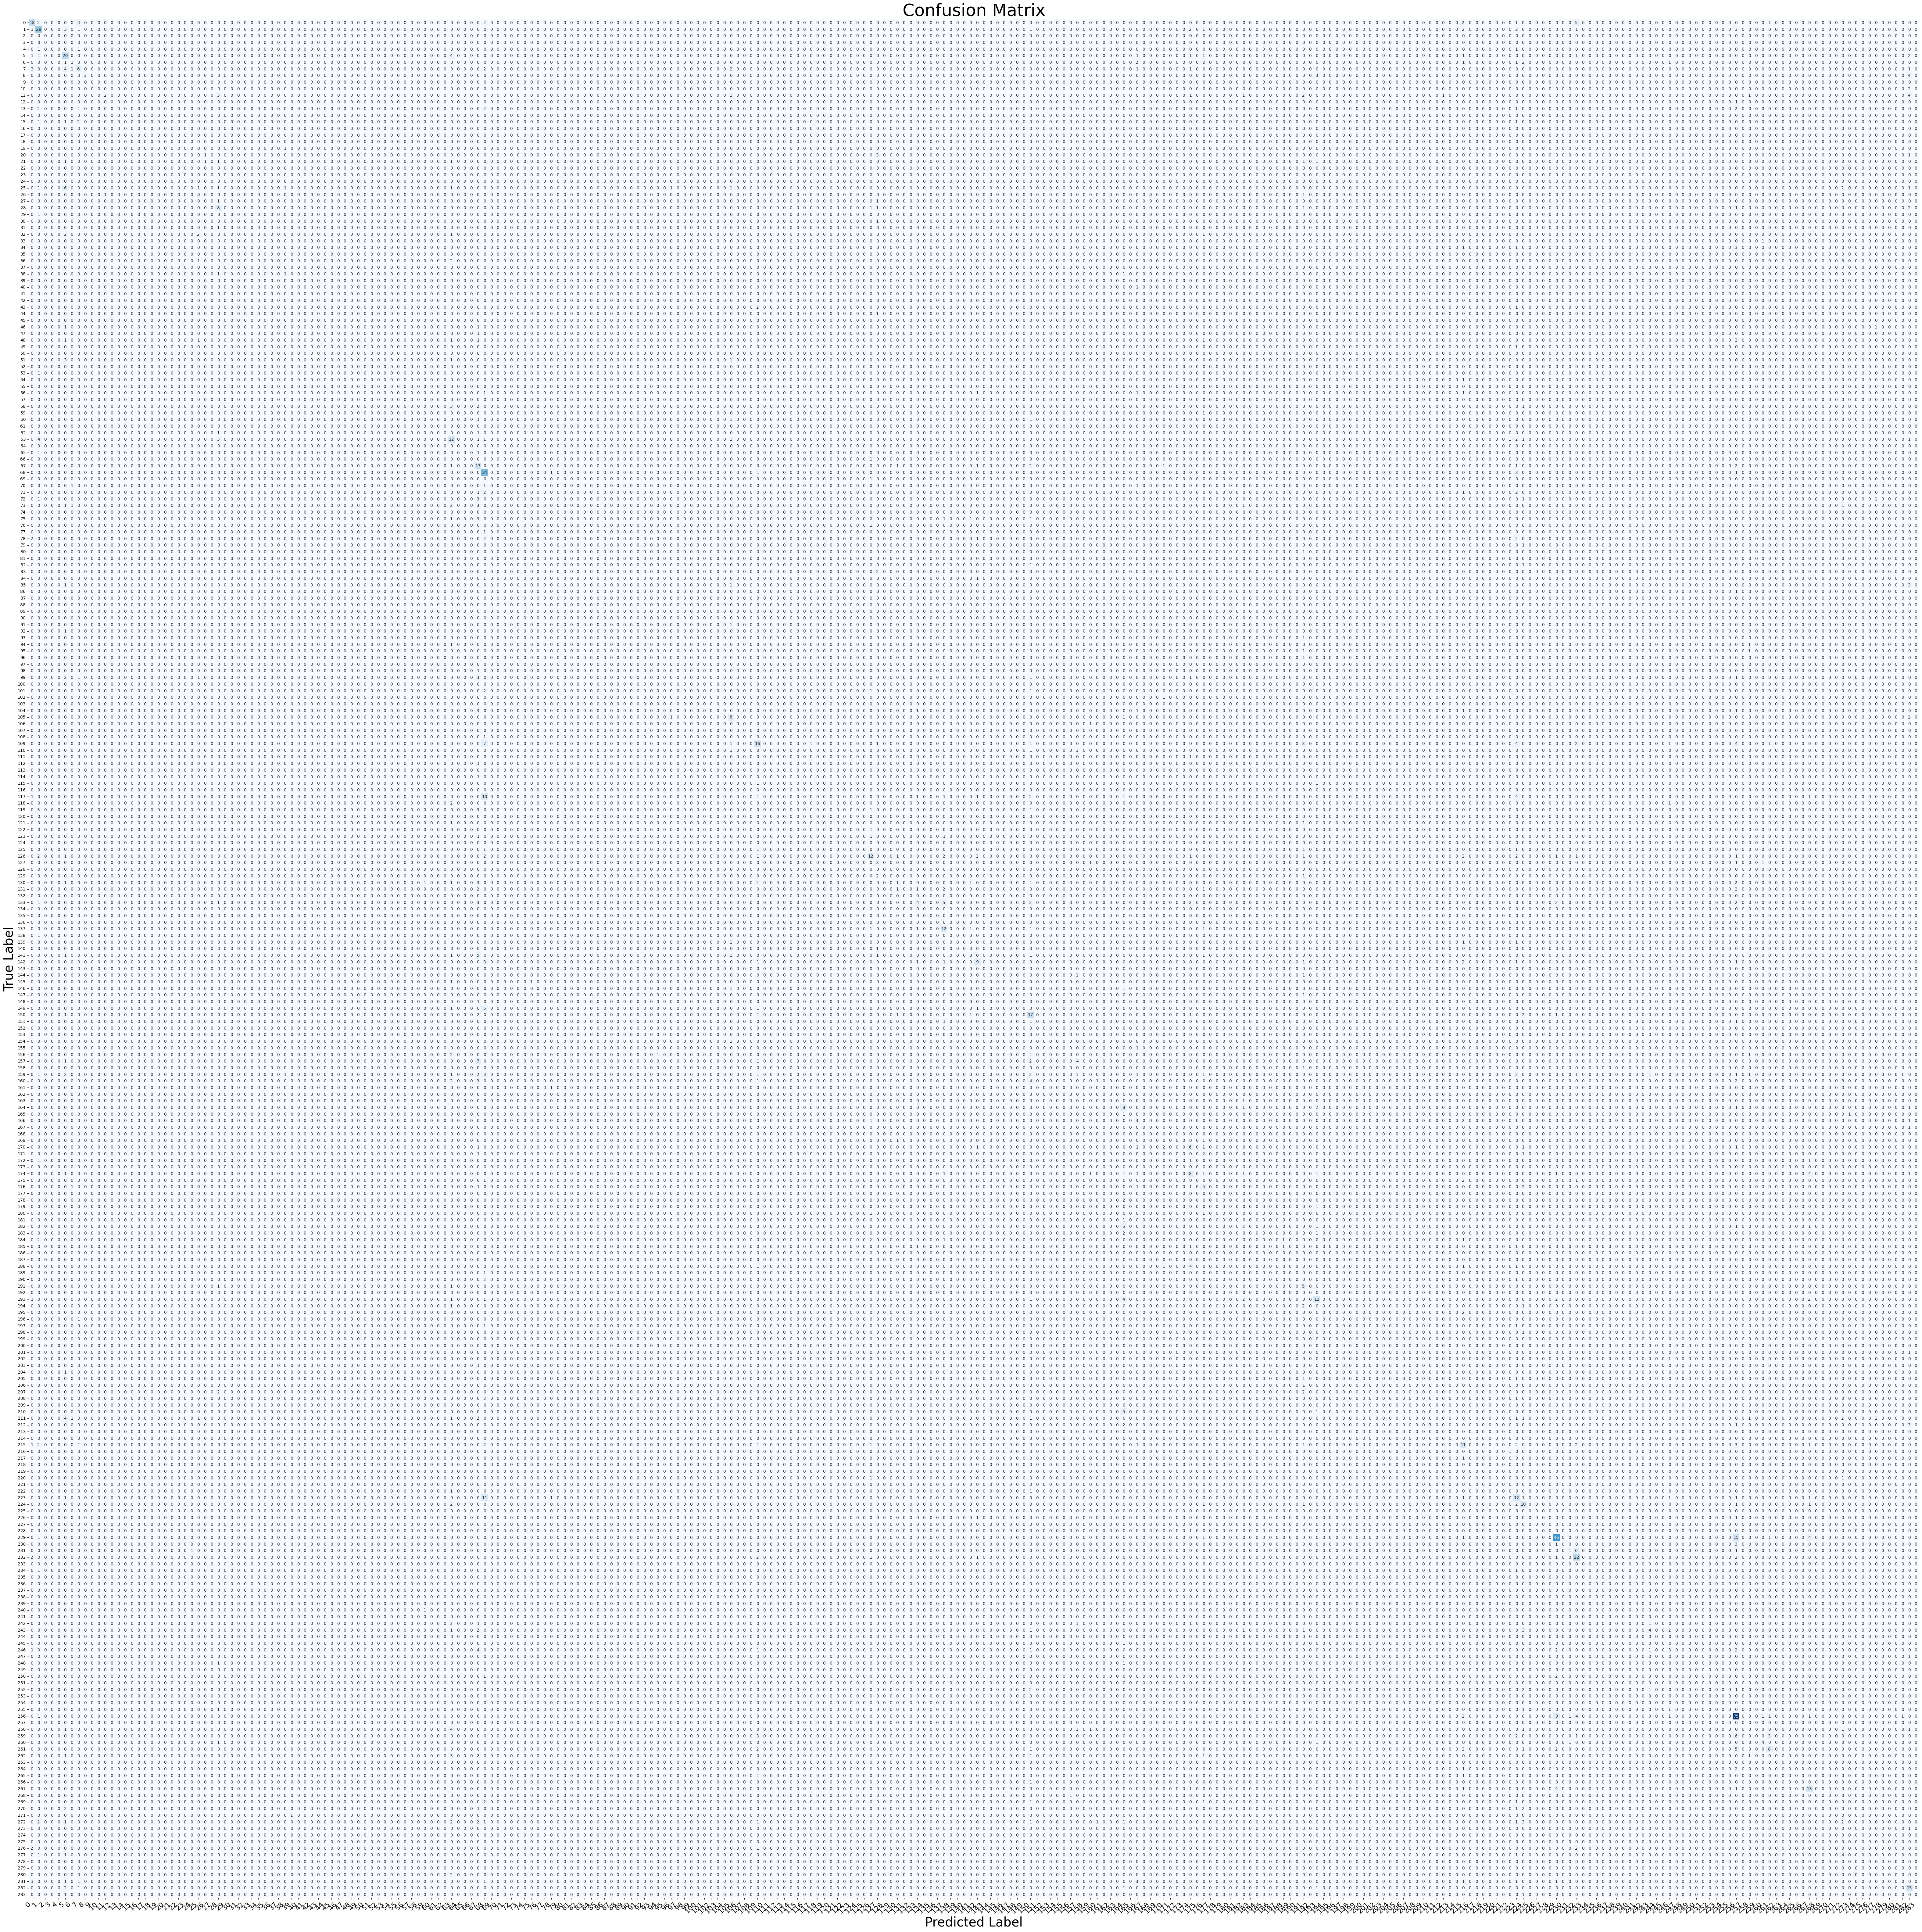

In [21]:
## - Preprocessing
features = []
labels = []
for feature, label in val_ds:
    features.append(feature)
    labels.append(label)

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)
labels = np.argmax(labels, axis=1)

## - Pred
y_pred = model_8c2f.predict(features)
y_pred_classes = np.argmax(y_pred, axis=1)


## - Confusion Matrix
confusion = tf.math.confusion_matrix(labels=labels, predictions=y_pred_classes)

plt.figure(figsize=(80, 80))

sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.xlabel('Predicted Label', fontsize=30)
plt.xticks(rotation=45, ha="right", fontsize=16)

plt.ylabel('True Label', fontsize=30)

plt.title('Confusion Matrix', fontsize=40)
plt.show()

<br />
<br />

----------

### Model 8C2F Basic
- No data augmentation
- batch_size : 32

In [22]:
mlflow.end_run()

mlflow.tensorflow.autolog(log_every_epoch=True,
                          registered_model_name="model_8C2F_V1_NDA")

model_8c2f.fit(
    train_ds,
    epochs=100,
    batch_size=32,
    validation_data=val_ds,
    callbacks=[tensorboard_callback]
)

2024/03/18 11:51:26 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8c2909089e1e4c9a8e6a8be05506c129', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2024/03/18 11:51:26 INFO mlflow.types.utils: MLflow 2.9.0 introduces model signature with new data types for lists and dictionaries. For input such as Dict[str, Union[scalars, List, Dict]], we infer dictionary values types as `List -> Array` and `Dict -> Object`. 
2024/03/18 11:51:27 INFO mlflow.types.utils: MLflow 2.9.0 introduces model signature with new data types for lists and dictionaries. For input such as Dict[str, Union[scalars, List, Dict]], we infer dictionary values types as `List -> Array` and `Dict -> Object`. 


Epoch 1/100
 5/99 [>.............................] - ETA: 1s - loss: 3.2994 - accuracy: 0.2469 - f1_score: 0.2469 - precision: 0.5610 - recall: 0.0719 - top3: 0.4062 - top5: 0.4906

98/99 [============================>.] - ETA: 0s - loss: 3.1582 - accuracy: 0.2467 - f1_score: 0.2467 - precision: 0.6223 - recall: 0.0730 - top3: 0.4377 - top5: 0.5397

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


99/99 [==============================] - 3s 31ms/step - loss: 3.1563 - accuracy: 0.2473 - f1_score: 0.2473 - precision: 0.6243 - recall: 0.0733 - top3: 0.4382 - top5: 0.5398 - val_loss: 3.1710 - val_accuracy: 0.3111 - val_f1_score: 0.3111 - val_precision: 0.7680 - val_recall: 0.0610 - val_top3: 0.5149 - val_top5: 0.5911
Epoch 2/100
99/99 [==============================] - 3s 31ms/step - loss: 3.1562 - accuracy: 0.2484 - f1_score: 0.2484 - precision: 0.6248 - recall: 0.0751 - top3: 0.4398 - top5: 0.5385 - val_loss: 3.1718 - val_accuracy: 0.3111 - val_f1_score: 0.3111 - val_precision: 0.8430 - val_recall: 0.0648 - val_top3: 0.5098 - val_top5: 0.6038
Epoch 3/100
99/99 [==============================] - 2s 20ms/step - loss: 3.1426 - accuracy: 0.2509 - f1_score: 0.2509 - precision: 0.6391 - recall: 0.0773 - top3: 0.4490 - top5: 0.5415 - val_loss: 3.1722 - val_accuracy: 0.3156 - val_f1_score: 0.3156 - val_precision: 0.8361 - val_recall: 0.0648 - val_top3: 0.5175 - val_top5: 0.5987
Epoch 4/10

Registered model 'model_8C2F_V1_NDA' already exists. Creating a new version of this model...
2024/03/18 11:57:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: model_8C2F_V1_NDA, version 2
Created version '2' of model 'model_8C2F_V1_NDA'.


<br />
<br />

----------

### Model 8C2F Basic
- No data augmentation
- batch_size : 64

In [23]:
mlflow.end_run()

mlflow.tensorflow.autolog(log_every_epoch=True,
                          registered_model_name="model_8C2F_V1_NDA")

model_8c2f.fit(
    train_ds,
    epochs=100,
    batch_size=64,
    validation_data=val_ds,
    callbacks=[tensorboard_callback]
)

2024/03/18 11:57:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '64e3688407d1422db53f0bfe239b36f2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2024/03/18 11:57:16 INFO mlflow.types.utils: MLflow 2.9.0 introduces model signature with new data types for lists and dictionaries. For input such as Dict[str, Union[scalars, List, Dict]], we infer dictionary values types as `List -> Array` and `Dict -> Object`. 
2024/03/18 11:57:17 INFO mlflow.types.utils: MLflow 2.9.0 introduces model signature with new data types for lists and dictionaries. For input such as Dict[str, Union[scalars, List, Dict]], we infer dictionary values types as `List -> Array` and `Dict -> Object`. 


Epoch 1/100
 5/99 [>.............................] - ETA: 1s - loss: 3.0291 - accuracy: 0.2500 - f1_score: 0.2500 - precision: 0.6304 - recall: 0.0906 - top3: 0.4500 - top5: 0.5594 

98/99 [============================>.] - ETA: 0s - loss: 2.9746 - accuracy: 0.2833 - f1_score: 0.2833 - precision: 0.6515 - recall: 0.1004 - top3: 0.4777 - top5: 0.5789

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


99/99 [==============================] - 3s 31ms/step - loss: 2.9718 - accuracy: 0.2836 - f1_score: 0.2836 - precision: 0.6536 - recall: 0.1009 - top3: 0.4780 - top5: 0.5797 - val_loss: 3.0979 - val_accuracy: 0.3416 - val_f1_score: 0.3416 - val_precision: 0.8344 - val_recall: 0.0800 - val_top3: 0.5333 - val_top5: 0.6152
Epoch 2/100
99/99 [==============================] - 3s 31ms/step - loss: 2.9427 - accuracy: 0.2869 - f1_score: 0.2869 - precision: 0.6498 - recall: 0.1001 - top3: 0.4806 - top5: 0.5764 - val_loss: 3.0900 - val_accuracy: 0.3530 - val_f1_score: 0.3530 - val_precision: 0.8155 - val_recall: 0.0870 - val_top3: 0.5302 - val_top5: 0.6229
Epoch 3/100
99/99 [==============================] - 3s 34ms/step - loss: 2.9556 - accuracy: 0.2825 - f1_score: 0.2825 - precision: 0.6565 - recall: 0.0955 - top3: 0.4837 - top5: 0.5813 - val_loss: 3.0755 - val_accuracy: 0.3403 - val_f1_score: 0.3403 - val_precision: 0.8333 - val_recall: 0.0825 - val_top3: 0.5346 - val_top5: 0.6235
Epoch 4/10

Registered model 'model_8C2F_V1_NDA' already exists. Creating a new version of this model...
2024/03/18 12:02:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: model_8C2F_V1_NDA, version 3
Created version '3' of model 'model_8C2F_V1_NDA'.


<br />
<br />

----------

### Model 8C2F Basic
- No data augmentation
- batch_size : 128

In [24]:
mlflow.end_run()

mlflow.tensorflow.autolog(log_every_epoch=True,
                          registered_model_name="model_8C2F_V1_NDA")

model_8c2f.fit(
    train_ds,
    epochs=100,
    batch_size=128,
    validation_data=val_ds,
    callbacks=[tensorboard_callback]
)

2024/03/18 12:02:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '21a1783957b14dadb1e49a0c90c2b442', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2024/03/18 12:02:53 INFO mlflow.types.utils: MLflow 2.9.0 introduces model signature with new data types for lists and dictionaries. For input such as Dict[str, Union[scalars, List, Dict]], we infer dictionary values types as `List -> Array` and `Dict -> Object`. 
2024/03/18 12:02:53 INFO mlflow.types.utils: MLflow 2.9.0 introduces model signature with new data types for lists and dictionaries. For input such as Dict[str, Union[scalars, List, Dict]], we infer dictionary values types as `List -> Array` and `Dict -> Object`. 


Epoch 1/100
 5/99 [>.............................] - ETA: 1s - loss: 2.9630 - accuracy: 0.2844 - f1_score: 0.2844 - precision: 0.6341 - recall: 0.0812 - top3: 0.5000 - top5: 0.5656

98/99 [============================>.] - ETA: 0s - loss: 2.8916 - accuracy: 0.2860 - f1_score: 0.2860 - precision: 0.6370 - recall: 0.1049 - top3: 0.4973 - top5: 0.5915

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


99/99 [==============================] - 3s 29ms/step - loss: 2.8883 - accuracy: 0.2866 - f1_score: 0.2866 - precision: 0.6377 - recall: 0.1047 - top3: 0.4983 - top5: 0.5924 - val_loss: 3.0830 - val_accuracy: 0.3498 - val_f1_score: 0.3498 - val_precision: 0.7688 - val_recall: 0.0844 - val_top3: 0.5340 - val_top5: 0.6279
Epoch 2/100
99/99 [==============================] - 1s 15ms/step - loss: 2.8722 - accuracy: 0.2990 - f1_score: 0.2990 - precision: 0.6735 - recall: 0.1140 - top3: 0.4972 - top5: 0.5928 - val_loss: 3.1038 - val_accuracy: 0.3537 - val_f1_score: 0.3537 - val_precision: 0.7965 - val_recall: 0.0870 - val_top3: 0.5429 - val_top5: 0.6216
Epoch 3/100
99/99 [==============================] - 3s 33ms/step - loss: 2.8987 - accuracy: 0.2955 - f1_score: 0.2955 - precision: 0.6534 - recall: 0.1098 - top3: 0.4915 - top5: 0.5878 - val_loss: 3.0966 - val_accuracy: 0.3479 - val_f1_score: 0.3479 - val_precision: 0.8023 - val_recall: 0.0876 - val_top3: 0.5333 - val_top5: 0.6254
Epoch 4/10

Registered model 'model_8C2F_V1_NDA' already exists. Creating a new version of this model...
2024/03/18 12:08:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: model_8C2F_V1_NDA, version 4
Created version '4' of model 'model_8C2F_V1_NDA'.


<br />
<br />

----------

### Model 8C2F Basic - 200 Epochs
- No data augmentation
- epoch : 200
- batch_size : 128

In [25]:
mlflow.end_run()

mlflow.tensorflow.autolog(log_every_epoch=True,
                          registered_model_name="model_8C2F_V1_NDA")

model_8c2f.fit(
    train_ds,
    epochs=200,
    batch_size=128,
    validation_data=val_ds,
    callbacks=[tensorboard_callback]
)

2024/03/18 12:08:02 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a31f4800d1004778a93a01172072b38b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2024/03/18 12:08:02 INFO mlflow.types.utils: MLflow 2.9.0 introduces model signature with new data types for lists and dictionaries. For input such as Dict[str, Union[scalars, List, Dict]], we infer dictionary values types as `List -> Array` and `Dict -> Object`. 
2024/03/18 12:08:02 INFO mlflow.types.utils: MLflow 2.9.0 introduces model signature with new data types for lists and dictionaries. For input such as Dict[str, Union[scalars, List, Dict]], we infer dictionary values types as `List -> Array` and `Dict -> Object`. 


Epoch 1/200
 5/99 [>.............................] - ETA: 1s - loss: 2.8655 - accuracy: 0.3031 - f1_score: 0.3031 - precision: 0.7660 - recall: 0.1125 - top3: 0.4875 - top5: 0.6000 

98/99 [============================>.] - ETA: 0s - loss: 2.8251 - accuracy: 0.3013 - f1_score: 0.3013 - precision: 0.6953 - recall: 0.1186 - top3: 0.5077 - top5: 0.6130

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


99/99 [==============================] - 3s 29ms/step - loss: 2.8203 - accuracy: 0.3022 - f1_score: 0.3022 - precision: 0.6973 - recall: 0.1192 - top3: 0.5091 - top5: 0.6143 - val_loss: 3.1193 - val_accuracy: 0.3467 - val_f1_score: 0.3467 - val_precision: 0.7809 - val_recall: 0.0883 - val_top3: 0.5302 - val_top5: 0.6152
Epoch 2/200
99/99 [==============================] - 4s 38ms/step - loss: 2.8226 - accuracy: 0.3060 - f1_score: 0.3060 - precision: 0.6626 - recall: 0.1125 - top3: 0.5037 - top5: 0.6067 - val_loss: 3.0951 - val_accuracy: 0.3479 - val_f1_score: 0.3479 - val_precision: 0.7600 - val_recall: 0.0965 - val_top3: 0.5352 - val_top5: 0.6184
Epoch 3/200
99/99 [==============================] - 2s 16ms/step - loss: 2.8506 - accuracy: 0.2984 - f1_score: 0.2984 - precision: 0.6552 - recall: 0.1122 - top3: 0.4980 - top5: 0.5958 - val_loss: 3.1058 - val_accuracy: 0.3524 - val_f1_score: 0.3524 - val_precision: 0.7713 - val_recall: 0.0921 - val_top3: 0.5340 - val_top5: 0.6197
Epoch 4/20

Registered model 'model_8C2F_V1_NDA' already exists. Creating a new version of this model...
2024/03/18 12:17:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: model_8C2F_V1_NDA, version 5
Created version '5' of model 'model_8C2F_V1_NDA'.
